# RAG Goal Step Prediction (GSP)

`Goal step Prediction` for `Source Space`

- input: (action sequence) (target space spatial information & inventory) (target space current space).

- output: (action sequence of the target space for achieving the subgoals).


`Credits to`

- https://github.com/svpino/youtube-rag/blob/main/rag.ipynb

- Choongho Chung 2024

In [1]:
# Core Packages for LLM
import os
import langchain # not used
import openai # not used
import pinecone # noe used

# Defining Model
from dotenv import load_dotenv
from langchain_openai.chat_models import ChatOpenAI

# Defining Chain
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from operator import itemgetter

# Loading and Splitting
from langchain_community.document_loaders import TextLoader
from langchain.document_loaders import JSONLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Embedding Database
from langchain_openai.embeddings import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

# Retriever

# PATHS
from IPython.display import Image, display
common_image_path = './figures/'
common_data_path = './data/'

## 0-1. API Keys
- Get API KEYS from environment file and test model

In [2]:
# openai api
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(openai_api_key=openai.api_key, model="gpt-3.5-turbo")
#model.invoke("How can I write a paper?")

# pinecone api
PINECONE_ENV = 'gcp-starter'
pinecone.init(api_key=os.getenv("PINECONE_API_KEY"),
             environment=PINECONE_ENV)

AIMessage(content='Writing a paper can be a daunting task, but with the right approach and organization, it can be manageable. Here are some steps to help you write a paper:\n\n1. Choose a topic: Start by selecting a topic that interests you and that you have knowledge about. Make sure it is specific enough to be manageable but broad enough to provide enough information for your paper.\n\n2. Conduct research: Once you have your topic, start researching to gather information and sources. Use a variety of sources such as books, articles, websites, and interviews to gather relevant information.\n\n3. Create an outline: Organize your thoughts and ideas by creating an outline for your paper. This will help you structure your paper and ensure that you include all the necessary information.\n\n4. Write a thesis statement: Develop a clear and concise thesis statement that outlines the main argument or point of your paper. This will help guide your writing and keep you focused on your main poin


# 1. Current State 부
다음 아이템들을 수집해서 prompt input으로 들여보낸다.
- 소스공간의 공간 구성 정보
- 소스공간의 (input으로 들어감) action정보, 
- 소스공간의 (주지는 않음) goalstep 정보
- 소스공간의 inventory 정보

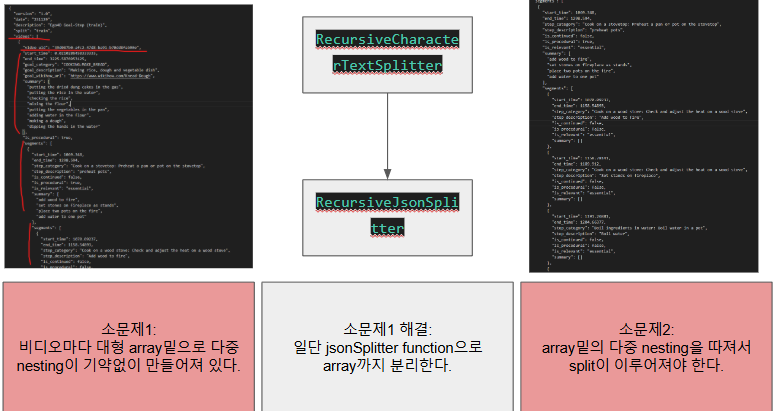

In [11]:
state_image_path = common_image_path + '02-chunking.png'
display(Image(state_image_path, width=600))

In [4]:
# input: inventory and spatial configuration of the current space
source_config = "null"
inven_config = "null"

# output: prompt pt1

# 2. Database 부
- annotation data에 대한 인코딩을 이용한 RAG DATABASE의 생성
    - nesting을 이용한 chunk의 형성

- dataset을 annotation부와 goalstep을 concatenate할 것인가?
- dataset을 annotation부와 goalsetp을 별개로 구성하고 query할 것인가?

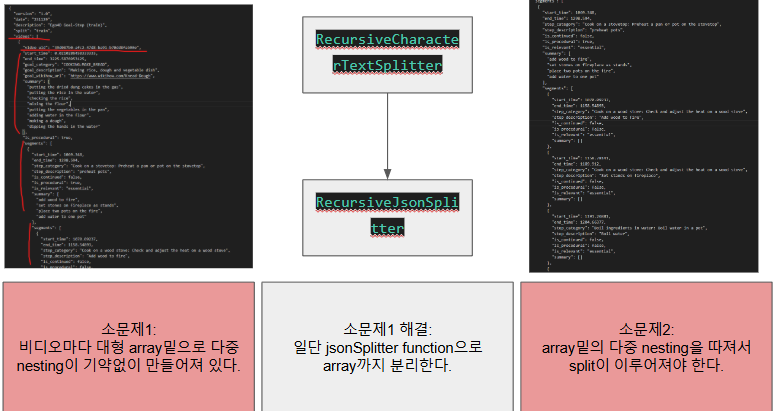

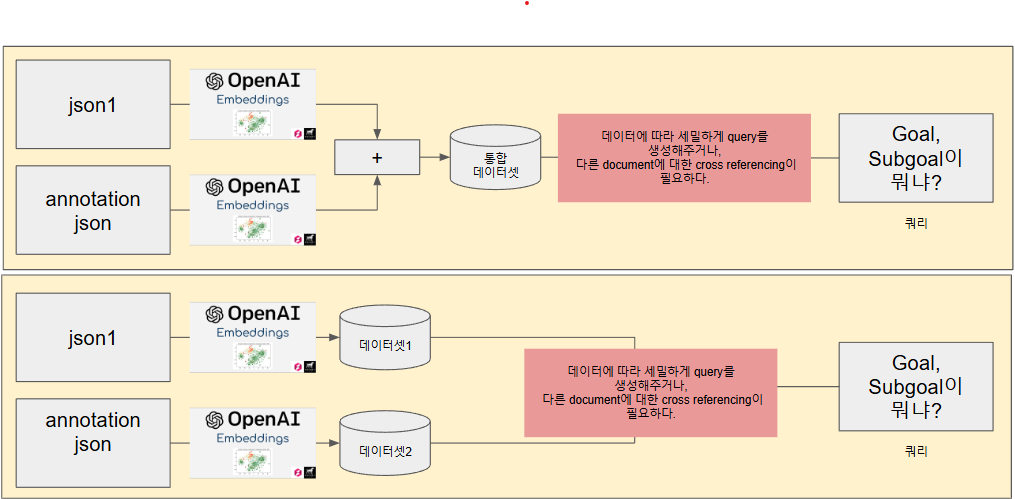

In [10]:
database_image1 = common_image_path + '02-chunking.png'
display(Image(database_image1, width=600))

database_image2 = common_image_path + '03-database-query.png'
display(Image(database_image2, width=600))

When loading documents in the json file, JSONLoader tries to make multiple documents in the specified array section.
1. we consider `"videos"` key as the name of the array to be split into documents

2. each item in the array wil become <u>one document</u>.

3. however, default JSONLoader <u><b>want all content inside the array item to be of TEXT</b></u>

4. <u>Since all items has a dict, array nested format</u>, this will return error.

5. We manually set text_content=False, as there are many {} and [] inside each item

6. Now, setting the `file_path`, `jq_cehema`, and `text_content` argument enables the JSONLoader instance to `.load()` our json file as multiple documents.

In [ ]:
# input: original annotation file
goalstep_original_annotation_path = common_data_path + "egogoal/v2/annotations/goalstep_train.json"
jq_schema = ".videos[]"
json_loader = JSONLoader(file_path=goalstep_original_annotation_path, jq_schema=jq_schema, text_content=False)
original_annotation_documents = json_loader.load()
print("length of documents is: ", len(original_annotation_documents))

# output: chunks of json
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=20)
documents1 = text_splitter.split_documents(original_annotation_documents)

# # input: manual annotation json files
# goalstep_manual_annotation_path = common_data_path + "path/to/your/annotation"
# json_loader = JSONLoader(goalstep_manual_annotation_path)
# manual_annotation_documents = json_loader.load()

# # output: chunks of json
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=20)
# documents2 = text_splitter.split_documents(manual_annotation_documents)

length of documents is:  583


In [7]:
# input: two separate embedding of chunks
embeddings = OpenAIEmbeddings()
vectorstore1 = DocArrayInMemorySearch.from_documents(documents1, embeddings)
#vectorstore2 = DocArrayInMemorySearch.from_documents(documents1, embeddings)
# output: database with separation or hierarchy

/usr/local/lib/python3.10/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


# 3-1. Retriever 부
`기본 쿼리`에 걸맞게 데이터베이스에서 관련된 공간정보, 인벤토리, 액션, goalstep 예시를 가져온다.

`기본 쿼리`는 여러개의 세부 쿼리로 다시 재생성되어서 적정한 데이터셋에서 서치를 수행할 수 있도록 해야 한다.
- `Multi-Query`-Retriver: `기본 쿼리`를 당장 여러개의 relevant한 질문으로 나눈다.
- `Parent-Document`-Retriver: 수직 구조에 따라서 relevant 한 데이터베이스 내의 document들을 다 보도록 유도한다.
- `Self-Querying`-Retriver: 문서의 metadata를 참조하여 필터링을 수행한다.
- `Ensemble`-Retriver: 코사인 유사도와 sparse retriver를 통합하여 둘다 쓴다.

출처: https://asidefine.tistory.com/298

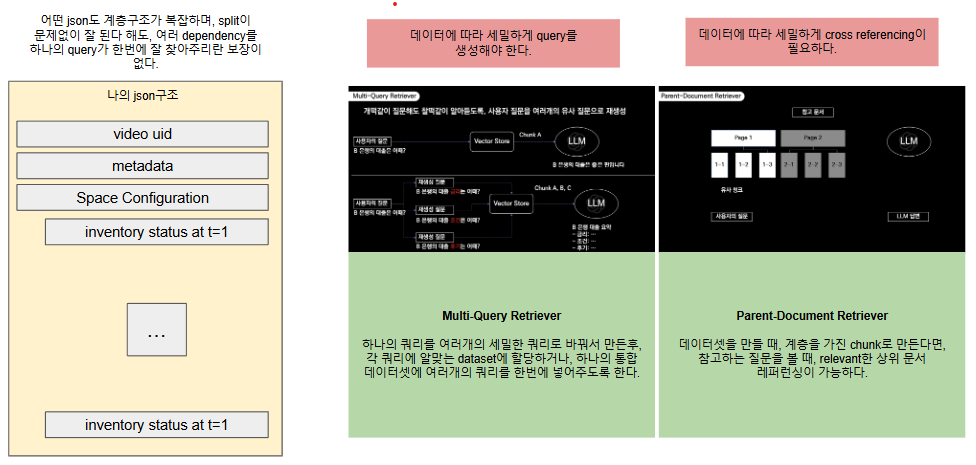

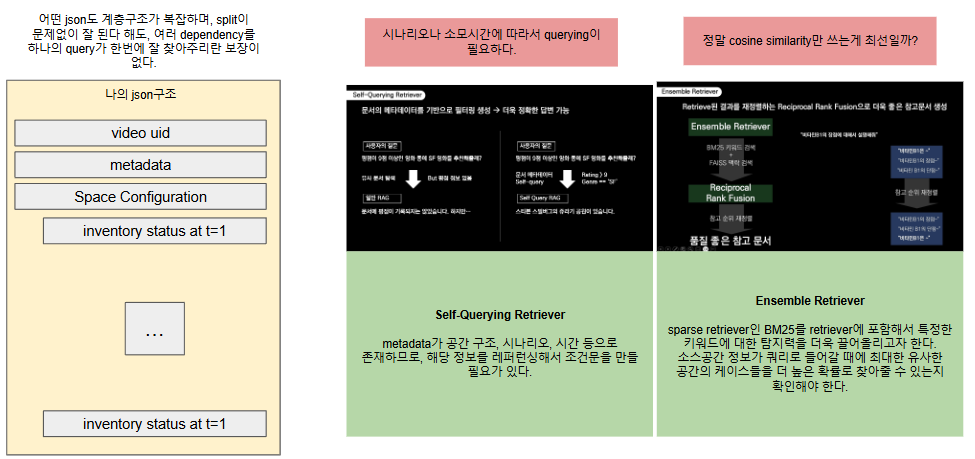

In [6]:
retriver_image1 = common_image_path + '03-retriever1.png'
retriver_image2= common_image_path + '03-retriever2.png'
display(Image(retriver_image1, width=800))
display(Image(retriver_image2, width=800))

In [ ]:
#기본 retriever for original database1
retriever1 = vectorstore1.as_retriever()
setup1 = RunnableParallel(context=retriever1, question=RunnablePassthrough())
chain = setup1 | prompt | model | parser
chain.invoke("What color is Patricia's car?")

chain = (
    {"context": vectorstore2.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)
chain.invoke("what was hinton's contribution?")


#기본 retriever: annotation database1


# 3-2. Database Querying
- 데이터베이스의 구조에 알맞게 querying을 수행한다.

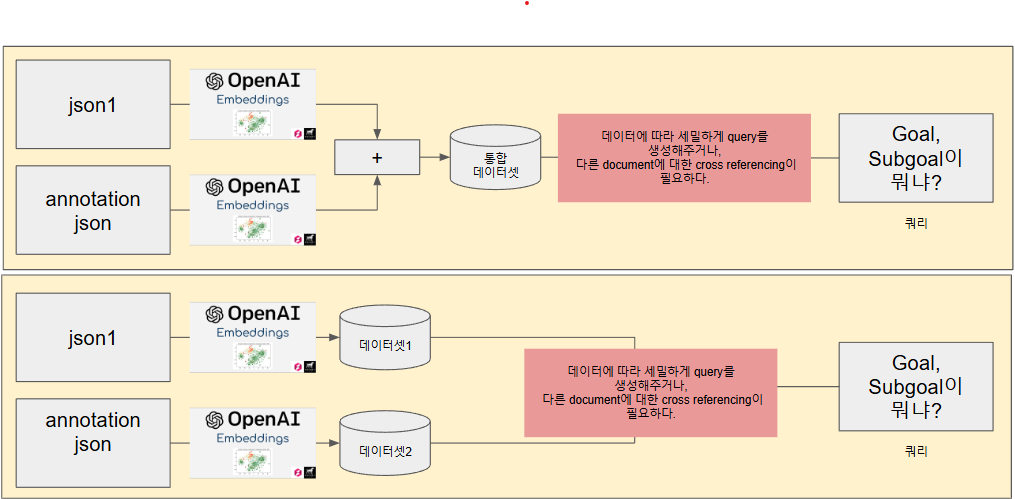

In [2]:
database_image3 = common_image_path + '03-database-query.png'
display(Image(database_image3))

In [ ]:
# For Concatenated Dataset



# For Separate Dataset




# 4. Querying

In [8]:
prompt_image = common_image_path + '04-prompt.png'
display(Image(prompt_image))

FileNotFoundError: No such file or directory: './figures/04-prompt.png'

FileNotFoundError: No such file or directory: './figures/04-prompt.png'

<IPython.core.display.Image object>

Querying Example and making chains

In [ ]:
# Define Prompt Template
template = """
Answer the question based on the context below. If you can't 
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
prompt.format(context="I am a researcher", question="How can I write a paper?")

# Define chain
parser = StrOutputParser()
chain1 = prompt | model | parser 
#chain_goal.invoke({
#    "context":"I am a researcher",
#    "question": "How can I write a paper?"
#})

# LATER (Connecting the chain to another chain)
source_spatial_context = "source context"
target_spatial_context = "target context"

### simpler chain
prompt_action = ChatPromptTemplate.from_template(
    "A source room with context of {source_spatial_context} is conducting {goalstep}. Your space has target context of {target_spatial_context}. You want to conduct the same goals as the source room with current spatial settings. What are the actions that must be taken?" 
)

chain_action = (
    {"source_spatial_context": itemgetter(source_spatial_context), "goalstep": chain1, "target_spatial_context": itemgetter(target_spatial_context)} | prompt_action | model | parser
)

In [ ]:
# 가장 기본적인 invokation
question_goal = "what is the goal of the player?"
chain1.invoke()

# multi-question invokation


# hierarchy invokation



# 5. 결과부
- Set Code and Just get Answer

# 6. 답변가공부
- Process Answer for visualization

# 7. 시각화부
- visualization strategy
- visualize goal steps, sub-goals, and actions in nested graphs